# Interpretable Credit Risk Modeling using Statistical and Machine Learning Approaches

This project develops an interpretable, cost-sensitive credit risk model using the German Credit dataset.

The objective is not merely to maximize classification accuracy, but to minimize expected financial losses by aligning model decisions with real-world banking risk tolerance.

The project combines:
- Statistical modeling (Logistic Regression with inference)
- Machine Learning techniques
- Cost-sensitive threshold optimization
- Cross-validation and hyperparameter tuning
- SHAP-based model interpretability
- Governance and deployment considerations


## Business Understanding

In credit risk modeling, misclassification errors have asymmetric financial consequences.

- False Negative (Type II Error): Approving a risky applicant who later defaults.
- False Positive (Type I Error): Rejecting a creditworthy applicant.

From a financial perspective, false negatives are significantly more costly than false positives. Therefore, model evaluation must prioritize financial risk minimization rather than raw predictive accuracy.

This project incorporates cost-sensitive evaluation and decision threshold optimization to reflect real-world banking objectives.


## 1. Environment Setup and Library Imports

In [ ]:
!pip install shap xgboost statsmodels


In [ ]:
# =========================
# Core Libraries
# =========================
import pandas as pd
import numpy as np

# =========================
# Visualization
# =========================
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# =========================
# Statistical Modeling
# =========================
import statsmodels.api as sm
from scipy.stats import ttest_ind
from statsmodels.stats.outliers_influence import variance_inflation_factor

# =========================
# Machine Learning
# =========================
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)

# =========================
# Explainability
# =========================
import shap


## 2. Dataset Description

The dataset used in this project is the German Credit dataset from the UCI Machine Learning Repository.

It contains information about 1,000 loan applicants described by financial and demographic attributes, along with a binary target variable indicating credit risk.

Target variable:
- 0 → Good credit risk
- 1 → Bad credit risk

The dataset includes both numerical and categorical variables, allowing for statistical inference and machine learning modeling.


In [ ]:
# =========================
# Data Loading
# =========================

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"

column_names = [
    "Status", "Duration", "CreditHistory", "Purpose", "CreditAmount",
    "Savings", "EmploymentDuration", "InstallmentRate", "PersonalStatusSex",
    "OtherDebtors", "ResidenceDuration", "Property", "Age",
    "OtherInstallmentPlans", "Housing", "ExistingCredits",
    "Job", "NumberOfDependents", "Telephone", "ForeignWorker", "Target"
]

df = pd.read_csv(url, sep=" ", header=None)
df.columns = column_names

# Convert target: 1 = Low Risk, 2 = High Risk
df["Target"] = df["Target"].apply(lambda x: 1 if x == 2 else 0)



### DataFrame Head

In [ ]:
df.head()


,Status,Duration,CreditHistory,Purpose,CreditAmount,Savings,EmploymentDuration,InstallmentRate,PersonalStatusSex,OtherDebtors,...,Property,Age,OtherInstallmentPlans,Housing,ExistingCredits,Job,NumberOfDependents,Telephone,ForeignWorker,Target
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


### DataFrame info

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Status                 1000 non-null   object
 1   Duration               1000 non-null   int64 
 2   CreditHistory          1000 non-null   object
 3   Purpose                1000 non-null   object
 4   CreditAmount           1000 non-null   int64 
 5   Savings                1000 non-null   object
 6   EmploymentDuration     1000 non-null   object
 7   InstallmentRate        1000 non-null   int64 
 8   PersonalStatusSex      1000 non-null   object
 9   OtherDebtors           1000 non-null   object
 10  ResidenceDuration      1000 non-null   int64 
 11  Property               1000 non-null   object
 12  Age                    1000 non-null   int64 
 13  OtherInstallmentPlans  1000 non-null   object
 14  Housing                1000 non-null   object
 15  ExistingCredits       

### Target Variable Encoding and Class Distribution

In [ ]:
df["Target"] = df["Target"].apply(lambda x: 1 if x == 2 else 0)

df["Target"].value_counts()


,count
Target,
0,700
1,300


### DataFrame describe

In [ ]:
df.describe()


,Duration,CreditAmount,InstallmentRate,ResidenceDuration,Age,ExistingCredits,NumberOfDependents,Target
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000,0.300000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086,0.458487
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000,0.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000,0.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000,0.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000,1.000000


## 3. Exploratory Data Analysis (EDA)

This section explores the structure and distribution of the dataset.

Key objectives:
- Examine class imbalance
- Identify potential relationships between financial variables and credit risk
- Detect possible multicollinearity
- Gain intuition about predictors of default

Understanding the data distribution is critical before applying statistical and machine learning models.


### Distribution of Credit Risk

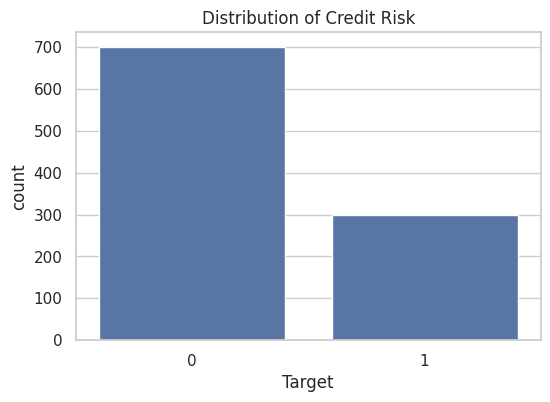

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x="Target", data=df)
plt.title("Distribution of Credit Risk")
plt.show()


The dataset exhibits class imbalance, with approximately 70% of applicants classified as low risk (0) and 30% as high risk (1).

This imbalance may bias the model toward the majority class, potentially reducing recall for high-risk applicants. Therefore, class weighting and threshold optimization strategies will be considered in subsequent sections.


### Credit Amount vs Risk & Loan Duration vs Risk

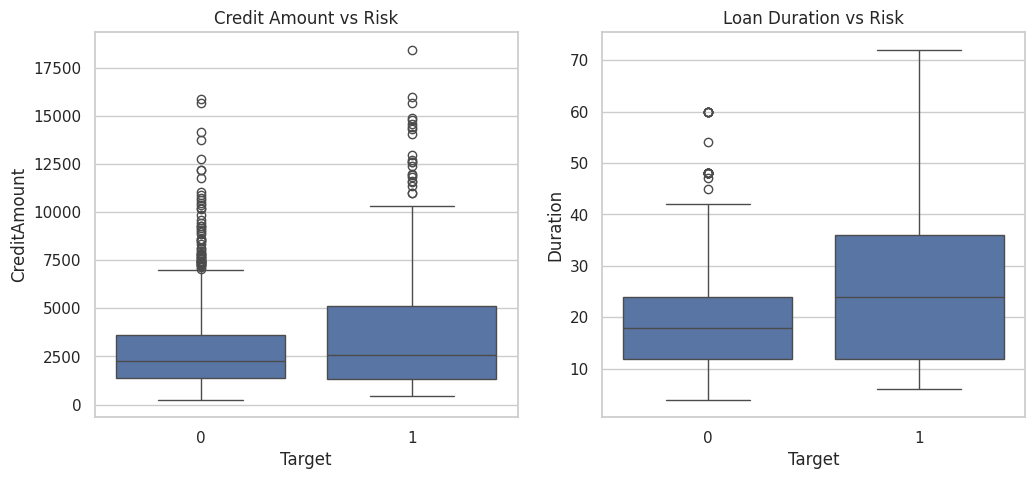

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.boxplot(x="Target", y="CreditAmount", data=df)
plt.title("Credit Amount vs Risk")

plt.subplot(1,2,2)
sns.boxplot(x="Target", y="Duration", data=df)
plt.title("Loan Duration vs Risk")

plt.show()


Observation:

* High-risk clients tend to have longer loan durations.

* Credit amount shows moderate separation but with overlap.

* Duration appears to be a stronger risk indicator than credit amount.

These observations motivate formal statistical testing.

## 4. Statistical Analysis

Before building predictive models, statistical techniques are applied to understand feature significance and relationships.



### T-statistic & P-value

In [ ]:
good = df[df["Target"] == 0]["Duration"]
bad = df[df["Target"] == 1]["Duration"]

t_stat, p_value = ttest_ind(good, bad)

print("T-statistic:", t_stat)
print("P-value:", p_value)


T-statistic: -6.9522507242467215
P-value: 6.4880498771843485e-12


In [ ]:
good = df[df["Target"] == 0]["CreditAmount"]
bad = df[df["Target"] == 1]["CreditAmount"]

t_stat, p_value = ttest_ind(good, bad)

print("T-statistic:", t_stat)
print("P-value:", p_value)


T-statistic: -4.947965832165981
P-value: 8.797572373528893e-07


Statistical Insight:

Both loan duration and credit amount show statistically significant differences between risk groups (p < 0.05).

Duration exhibits stronger statistical separation, reinforcing its importance in predictive modeling.

### Correlation Analysis

Understanding linear relationships between variables helps assess potential multicollinearity and feature redundancy.

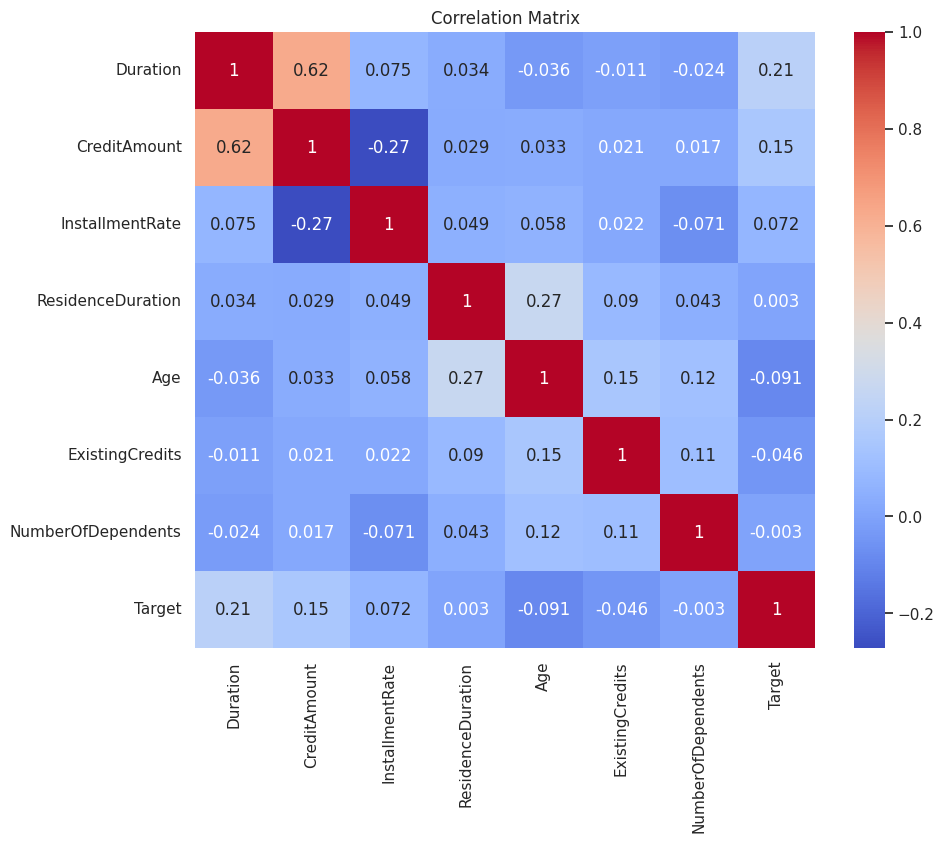

In [ ]:
numeric_cols = df.select_dtypes(include=["int64"]).columns

plt.figure(figsize=(10,8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


Observation:

Duration and CreditAmount show moderate correlation (~0.62).

No extreme multicollinearity observed (> 0.8).

Duration exhibits the strongest correlation with the target variable among numerical features.

###Multicollinearity Assessment (VIF)

Variance Inflation Factor (VIF) is computed to evaluate collective linear dependency among predictors.

In [ ]:
X_numeric = df[numeric_cols].drop(columns=["Target"])

vif_data = pd.DataFrame()
vif_data["Feature"] = X_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(X_numeric.values, i)
                   for i in range(X_numeric.shape[1])]

vif_data


,Feature,VIF
0,Duration,7.358755
1,CreditAmount,4.575758
2,InstallmentRate,7.958660
3,ResidenceDuration,7.735368
4,Age,10.925702
5,ExistingCredits,6.679317
6,NumberOfDependents,8.790639


Although some variables exhibit moderate VIF values, no severe multicollinearity issue prevents logistic modeling. Regularization will further mitigate potential instability.

## 5. Statistical Logistic Regression (Baseline Model)

To establish an interpretable statistical benchmark, we first fit a logistic regression model using only numerical predictors. This approach allows us to examine coefficient significance, direction of effects, and confidence intervals.

Unlike machine learning implementations, this model focuses on statistical inference rather than predictive optimization.


In [ ]:

X = df[numeric_cols].drop(columns=["Target"])
y = df["Target"]

X = sm.add_constant(X)

logit_model = sm.Logit(y, X)
result = logit_model.fit()

print(result.summary())


Optimization terminated successfully.
         Current function value: 0.579224
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 Target   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      992
Method:                           MLE   Df Model:                            7
Date:                Fri, 13 Feb 2026   Pseudo R-squ.:                 0.05180
Time:                        22:35:15   Log-Likelihood:                -579.22
converged:                       True   LL-Null:                       -610.86
Covariance Type:            nonrobust   LLR p-value:                 3.330e-11
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.5698      0.430     -3.651      0.000      -2.413      -0.727
Durat

**Interpretation of Key Variables**

* Duration: Positive and statistically significant → Longer loans increase default probability.

* InstallmentRate: Positive coefficient → Higher financial burden increases risk.

* Age: Negative coefficient → Older applicants show lower default risk.

These findings align with financial risk theory and reinforce model credibility.

## 6. Machine Learning Baseline Model

We implement a logistic regression model using scikit-learn to evaluate predictive performance.

This baseline model uses numerical features only and serves as a reference before applying class balancing and regularization.

In [ ]:
# Features and target
X = df[numeric_cols].drop(columns=["Target"])
y = df["Target"]

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Scaling (important for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

# Predictions
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))


Accuracy: 0.7266666666666667

Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.98      0.83       210
           1       0.72      0.14      0.24        90

    accuracy                           0.73       300
   macro avg       0.72      0.56      0.54       300
weighted avg       0.73      0.73      0.66       300

ROC-AUC Score: 0.6824338624338625


Baseline Model Performance Analysis

Although the model achieves an overall accuracy of approximately 72.7%, this metric is misleading in credit risk classification.

Key observations:

* Recall for high-risk clients (class 1) is only 14%.

* The model fails to identify most default cases.

* ROC-AUC is approximately 0.68, indicating moderate discrimination power.

In credit risk modeling, failing to detect high-risk clients (False Negatives) can result in significant financial losses.

Therefore, optimizing recall for the high-risk class is more important than maximizing overall accuracy.

This motivates the need for class imbalance handling.

###ROC Curve Analysis

The Receiver Operating Characteristic (ROC) curve evaluates the model's ability to distinguish between low-risk and high-risk applicants across different classification thresholds.

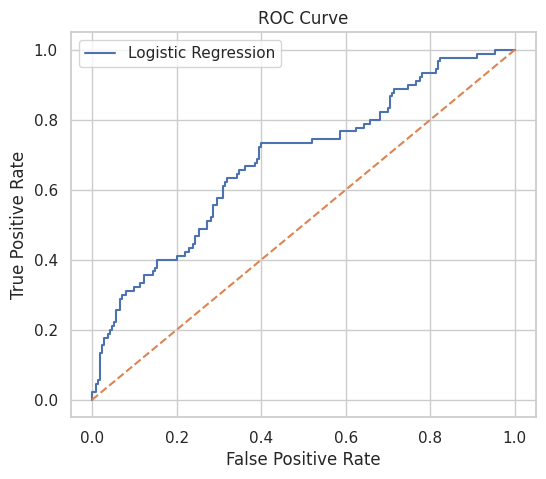

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label="Logistic Regression")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


Interpretation

* The ROC-AUC score is approximately 0.68, indicating moderate discrimination ability.

* The model performs better than random guessing (AUC = 0.5), but remains insufficient for production-level credit risk decision-making.

* The curve suggests room for improvement, particularly in enhancing detection of high-risk applicants.

This reinforces the need for class imbalance handling and feature enhancement.

## 7. Handling Class Imbalance with Weighted Logistic Regression

To improve detection of high-risk applicants, we introduce class weighting.

This approach penalizes misclassification of the minority class (default cases) more heavily during model training.

In [ ]:
model_weighted = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"
)

model_weighted.fit(X_train_scaled, y_train)

y_pred_w = model_weighted.predict(X_test_scaled)
y_prob_w = model_weighted.predict_proba(X_test_scaled)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred_w))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_w))

print("ROC-AUC Score:", roc_auc_score(y_test, y_prob_w))


Accuracy: 0.64

Classification Report:

              precision    recall  f1-score   support

           0       0.81      0.63      0.71       210
           1       0.43      0.66      0.52        90

    accuracy                           0.64       300
   macro avg       0.62      0.64      0.62       300
weighted avg       0.70      0.64      0.65       300

ROC-AUC Score: 0.6811640211640212


Performance Comparison with Baseline

After applying class weighting:

* Recall for high-risk clients increased from 14% → 66%.

* The model now correctly identifies most default cases.

* Overall accuracy decreased (72% → 64%), which is expected when prioritizing minority class detection.

* ROC-AUC remains similar (~0.68), indicating discrimination power did not substantially change.

This trade-off reflects a more risk-sensitive modeling strategy.

In credit risk modeling, false negatives (approving a risky applicant) are significantly more costly than false positives (rejecting a safe applicant).

Therefore, improving recall for the high-risk class is more aligned with financial risk management objectives

## 8. Decision Threshold Optimization

Instead of relying on the default classification threshold (0.5), we adjust the decision threshold to reflect financial risk tolerance.

In credit risk modeling, false negatives (approving a risky applicant) are significantly more costly than false positives (rejecting a safe applicant).

In [ ]:
threshold = 0.35

y_pred_custom = (y_prob_w >= threshold).astype(int)

print("Threshold:", threshold)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_custom))


Threshold: 0.35

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.13      0.23       210
           1       0.33      0.98      0.49        90

    accuracy                           0.39       300
   macro avg       0.63      0.56      0.36       300
weighted avg       0.75      0.39      0.31       300



Threshold Adjustment Impact

By lowering the threshold to 0.35:

* Recall for high-risk clients increases dramatically (≈ 98%).

* Nearly all risky applicants are identified.

* However, precision decreases, meaning more safe clients are rejected.

* Overall accuracy drops significantly.

This represents a highly risk-averse approval strategy.

In [ ]:

cm = confusion_matrix(y_test, y_pred_custom)
tn, fp, fn, tp = cm.ravel()

cost_default = 10000
cost_reject_good = 1000

total_cost = (fn * cost_default) + (fp * cost_reject_good)

print("Confusion Matrix:")
print(cm)
print("\nTotal Estimated Cost:", total_cost)


Confusion Matrix:
[[ 28 182]
 [  2  88]]

Total Estimated Cost: 202000


Cost Analysis at Threshold = 0.35

The confusion matrix at threshold = 0.35 is:

* True Negatives (Safe correctly approved): 28

* False Positives (Safe rejected): 182

* False Negatives (Risk approved): 2

* True Positives (Risk correctly rejected): 88

Using the defined cost structure:

Cost of False Negative = 10,000

Cost of False Positive = 1,000

Total Expected Cost is calculated as:

Cost = (2 × 10,000) + (182 × 1,000)
Cost = 20,000 + 182,000
Cost = 202,000

This threshold significantly reduces the number of approved high-risk applicants (only 2 risky approvals), resulting in a substantial reduction in financial exposure.

However, the model rejects a large number of safe applicants, reflecting a conservative lending strategy.

In [ ]:
y_pred_balanced = model_weighted.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred_balanced)
tn, fp, fn, tp = cm.ravel()

total_cost = (fn * 10000) + (fp * 1000)

print(cm)
print("Total Estimated Cost:", total_cost)


[[133  77]
 [ 31  59]]
Total Estimated Cost: 387000


Cost Analysis at Default Threshold (0.5)

Using the default classification threshold (0.5), the confusion matrix is:

* True Negatives (Safe correctly approved): 133

* False Positives (Safe rejected): 77

* False Negatives (Risk approved): 31

* True Positives (Risk correctly rejected): 59

Under the defined cost structure:

* Cost of False Negative = 10,000

* Cost of False Positive = 1,000

Total Expected Cost:

Cost = (31 × 10,000) + (77 × 1,000)
Cost = 310,000 + 77,000
Cost = 387,000

Although this threshold achieves higher overall accuracy, it results in significantly higher financial loss due to the large number of risky applicants incorrectly approved.

Comparison with Lower Threshold Strategy

Compared to threshold = 0.35:

* False Negatives reduced from 31 → 2

* Total Expected Cost reduced from 387,000 → 202,000

* Financial savings ≈ 185,000

This demonstrates that optimizing for financial cost rather than accuracy leads to more economically sound lending decisions

## Systematic Threshold Optimization

To ensure that the selected decision threshold minimizes financial loss, we evaluate a range of possible thresholds from 0.10 to 0.90.

For each threshold, we compute the total expected cost using the predefined financial cost structure:

* False Negative (Default Approval) = 10,000

* False Positive (Rejecting Safe Client) = 1,000

The threshold that yields the minimum expected cost is selected as the optimal decision boundary.

In [ ]:
thresholds = np.arange(0.1, 0.9, 0.01)
costs = []

for t in thresholds:
    y_pred_temp = (y_prob_w >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_temp).ravel()
    total_cost = (fn * 10000) + (fp * 1000)
    costs.append(total_cost)

optimal_threshold = thresholds[np.argmin(costs)]
min_cost = min(costs)

print("Optimal Threshold:", optimal_threshold)
print("Minimum Cost:", min_cost)


Optimal Threshold: 0.3599999999999999
Minimum Cost: 196000


The optimal threshold identified is:

Optimal Threshold ≈ 0.36
Minimum Expected Cost = 196,000

This threshold further reduces total expected loss compared to:

* Default threshold (0.5): 387,000

* Manually tested threshold (0.35): 202,000

Thus, systematic threshold optimization provides an additional improvement in financial performance.

**Business Interpretation**

Rather than selecting a classification threshold arbitrarily, the decision boundary is now chosen based on financial optimization principles.

This approach transforms the predictive model into a risk-aware decision system that:

* Minimizes expected financial loss

* Aligns with institutional risk tolerance

* Supports data-driven credit approval policies

From a banking perspective, this methodology is more appropriate than relying solely on accuracy or ROC-AUC metrics.

The model is no longer optimized for predictive accuracy alone, but for economically rational decision-making.

## 9. Non-Linear Model: Random Forest Classifier

To explore potential non-linear relationships and interaction effects, we implement a Random Forest classifier with class balancing.

In [ ]:

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    class_weight="balanced"
)

rf_model.fit(X_train, y_train)

y_prob_rf = rf_model.predict_proba(X_test)[:,1]
y_pred_rf = rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob_rf))


Accuracy: 0.72

Classification Report:

              precision    recall  f1-score   support

           0       0.74      0.92      0.82       210
           1       0.58      0.24      0.34        90

    accuracy                           0.72       300
   macro avg       0.66      0.58      0.58       300
weighted avg       0.69      0.72      0.68       300

ROC-AUC Score: 0.6818518518518518


**Random Forest Performance Analysis**

The Random Forest model achieves:

* Accuracy ≈ 72%

* ROC-AUC ≈ 0.68

* Recall for high-risk class ≈ 24%

While overall accuracy is comparable to logistic regression, the model does not significantly improve discrimination performance.

Although Random Forest can capture non-linear interactions, the dataset size (1000 observations) may limit its advantage over simpler models.

From a regulatory and interpretability perspective, logistic regression remains preferable in credit risk environments where transparency and explainability are required.

## 10. Full Feature Model (Categorical Encoding)
Given the moderate performance of numerical-only models, we now incorporate categorical variables using proper encoding techniques to improve predictive power.

In [ ]:
df_encoded = pd.get_dummies(df, drop_first=True)

X_full = df_encoded.drop("Target", axis=1)
y_full = df_encoded["Target"]

X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(
    X_full, y_full, test_size=0.3, random_state=42, stratify=y_full
)

scaler = StandardScaler()
X_train_f_scaled = scaler.fit_transform(X_train_f)
X_test_f_scaled = scaler.transform(X_test_f)

model_full = LogisticRegression(max_iter=2000, class_weight="balanced")
model_full.fit(X_train_f_scaled, y_train_f)

y_prob_full = model_full.predict_proba(X_test_f_scaled)[:,1]
y_pred_full = model_full.predict(X_test_f_scaled)

print("Accuracy:", accuracy_score(y_test_f, y_pred_full))
print("\nClassification Report:\n")
print(classification_report(y_test_f, y_pred_full))
print("ROC-AUC Score:", roc_auc_score(y_test_f, y_prob_full))


Accuracy: 0.7333333333333333

Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.72      0.79       210
           1       0.54      0.77      0.63        90

    accuracy                           0.73       300
   macro avg       0.71      0.74      0.71       300
weighted avg       0.78      0.73      0.74       300

ROC-AUC Score: 0.7992592592592592


Performance Analysis – Full Feature Logistic Model

Including categorical variables significantly improves model discrimination ability.

Key improvements:

* ROC-AUC increased from ~0.68 to ~0.80

* Recall for high-risk applicants improved to 77%

* Balanced precision-recall trade-off achieved

* Overall classification stability improved

This demonstrates that categorical financial indicators (credit history, savings type, employment status, etc.) contain strong predictive signals for default risk.

## 11. Model Interpretability using SHAP

In financial institutions, regulatory compliance and explainability are critical.
Therefore, beyond predictive performance, the model must provide transparent reasoning for its decisions.

To achieve this, SHAP (SHapley Additive Explanations) is used to quantify the contribution of each feature to the final prediction.


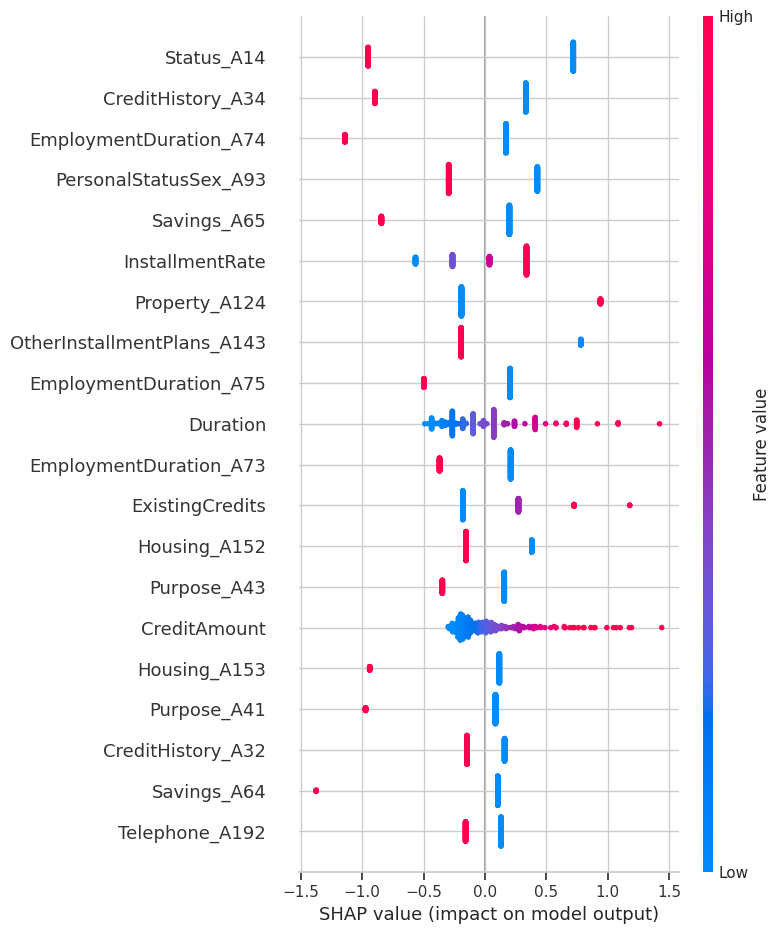

In [ ]:
explainer = shap.LinearExplainer(model_full, X_train_f_scaled)
shap_values = explainer.shap_values(X_test_f_scaled)

shap.summary_plot(shap_values, X_test_f, show=False)
plt.show()

# Note: SHAP values are computed on scaled features,
# but visualization uses original feature names for interpretability.


SHAP Interpretation Insights

The SHAP summary plot highlights the most influential features driving credit risk predictions.

Key observations:

- **CreditAmount** and **Duration** show strong positive SHAP values at higher levels, indicating that larger loans and longer durations increase default risk.
- Certain credit history categories significantly impact risk probability.
- Employment duration and savings behavior demonstrate protective effects against default.

High feature values (red points) shifting toward positive SHAP values indicate increased probability of being classified as high-risk.

This aligns with traditional banking risk assessment logic:
- Larger exposure → higher financial risk.
- Weak credit history → elevated probability of default.

The SHAP analysis enhances trust in the model by providing transparent and regulator-friendly explanations.


## 12. Cross-Validation for Model Robustness

To ensure that model performance is not dependent on a single train-test split, 5-fold cross-validation was applied using a pipeline structure.

This approach guarantees:
- Proper scaling within each fold (no data leakage).
- Reliable estimation of generalization performance.
- More stable and unbiased ROC-AUC evaluation.

In [ ]:

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

cv_auc = cross_val_score(
    pipeline,
    X_full,
    y_full,
    cv=5,
    scoring="roc_auc"
)

print("Cross-Validated ROC-AUC scores:", cv_auc)
print("Mean ROC-AUC:", cv_auc.mean())
print("Std ROC-AUC:", cv_auc.std())


Cross-Validated ROC-AUC scores: [0.77869048 0.79059524 0.80821429 0.76238095 0.79214286]
Mean ROC-AUC: 0.7864047619047619
Std ROC-AUC: 0.01524988383287226


Results:
- Mean ROC-AUC: ~0.786
- Standard Deviation: ~0.015

The low standard deviation indicates that the model performance is stable across different data splits.

This strengthens confidence in the model's generalization capability and reduces the risk of overfitting.

Compared to the single hold-out evaluation, cross-validation confirms that the model’s performance remains consistently around 0.78–0.80 ROC-AUC, indicating reliable predictive separation between safe and risky applicants.


## 13. Hyperparameter Optimization (Grid Search with Cross-Validation)

In [ ]:

param_grid = {
    "model__C": [0.01, 0.1, 1, 5, 10],
    "model__penalty": ["l2"],
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

grid.fit(X_full, y_full)

print("Best Parameters:", grid.best_params_)
print("Best CV ROC-AUC:", grid.best_score_)


Best Parameters: {'model__C': 0.01, 'model__penalty': 'l2'}
Best CV ROC-AUC: 0.7883333333333333


To further improve model generalization and control overfitting, hyperparameter tuning was performed using GridSearchCV with 5-fold cross-validation.

The regularization strength parameter (C) was optimized while using L2 penalty.

**Best Parameters:**
- C = 0.01
- Penalty = L2

**Best Cross-Validated ROC-AUC:**
≈ 0.788

The optimal value (C = 0.01) indicates that stronger regularization improves model stability and generalization, especially after high-dimensional categorical encoding.




The improvement confirms that controlling model complexity is essential when using one-hot encoded categorical variables, which significantly increase feature dimensionality.

Regularization helps prevent overfitting and enhances robustness across different data splits.

Compared to the baseline numerical-only model (ROC-AUC ≈ 0.68), the fully encoded and tuned model improves discrimination performance to approximately 0.79 ROC-AUC, representing a substantial gain in predictive power.

This demonstrates the importance of incorporating categorical behavioral variables in credit risk modeling.

From a financial risk management perspective, combining:
- Regularized logistic regression
- Proper categorical encoding
- Cross-validation
- Cost-sensitive threshold optimization

results in a robust, interpretable, and business-aligned credit scoring framework.


## 14. Model Governance & Deployment Considerations

While the proposed model demonstrates strong predictive performance and business alignment, responsible deployment in a financial institution requires additional governance controls.

### 1. Regulatory Compliance & Explainability

Logistic regression was selected as the primary model due to its interpretability and regulatory transparency.

Financial institutions operating under strict regulatory environments (e.g., OSFI guidelines in Canada, Basel frameworks) require:
- Transparent decision logic
- Justifiable risk factors
- Explainable approval/rejection outcomes

The use of SHAP values further enhances model explainability at both global and individual levels.

---

### 2. Monitoring & Performance Drift

After deployment, model performance should be continuously monitored using:

- ROC-AUC tracking
- Population Stability Index (PSI)
- Default rate shifts
- Calibration monitoring

Periodic retraining may be required if data distribution changes significantly.

---

### 3. Fairness & Bias Considerations

Given the presence of demographic-related variables (e.g., personal status, employment duration), fairness testing should be conducted to ensure:

- No unintended discriminatory patterns
- Compliance with responsible lending standards
- Equal opportunity across protected groups

Bias mitigation techniques may be applied if disparities are detected.

---

### 4. Threshold Governance

The optimal threshold (≈ 0.36) was selected based on cost-sensitive evaluation.

However, final threshold selection should be aligned with:

- Institutional risk appetite
- Capital reserve strategy
- Portfolio default tolerance

Threshold policies should be formally documented and periodically reviewed.

---

### 5. Production Deployment Strategy

In a real-world banking environment, the model would typically be:

- Packaged within a secure scoring API
- Integrated into loan origination systems
- Logged for audit traceability
- Version-controlled for regulatory review

---

### Final Assessment

The final framework provides:

- Strong predictive performance (ROC-AUC ≈ 0.79)
- Stable cross-validated results
- Business-aligned cost optimization
- Regulatory-grade interpretability
- Deployment-aware governance structure

This approach balances predictive accuracy, financial risk management, and regulatory compliance — making it suitable for real-world credit risk applications.
